# Module 11 Part 2: Optimizing Deep Neural Networks - Using Faster Optimizers

This module consists of 3 parts:

- **Part 1** - Vanishing/Exploding Gradient Problem

- **Part 2** - Using Faster Optimizers

- **Part 3** - Avoiding Overfitting through Regularization

Each part is provided in a separate notebook file. It is recommended that you follow the order of the notebooks.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Module-11-Part-2:-Optimizing-Deep-Neural-Networks---Using-Faster-Optimizers" data-toc-modified-id="Module-11-Part-2:-Optimizing-Deep-Neural-Networks---Using-Faster-Optimizers">Module 11 Part 2: Optimizing Deep Neural Networks - Using Faster Optimizers</a></span>
</li>
<li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents">Table of Contents</a></span>
</li>
<li><span><a href="#Using-Faster-Optimizers" data-toc-modified-id="Using-Faster-Optimizers">Using Faster Optimizers</a></span>
<ul class="toc-item">
<li><span><a href="#Exponentially-Weighted-Averages" data-toc-modified-id="Exponentially-Weighted-Averages">Exponentially Weighted Averages</a></span>
</li>
<li><span><a href="#Momentum-Optimization" data-toc-modified-id="Momentum-Optimization">Momentum Optimization</a></span>
</li>
<li><span><a href="#AdaGrad-Optimization" data-toc-modified-id="AdaGrad-Optimization">AdaGrad Optimization</a></span>
</li>
<li><span><a href="#RMSprop-Optimization" data-toc-modified-id="RMSprop-Optimization">RMSprop Optimization</a></span>
</li>
<li><span><a href="#Adam-Optimization" data-toc-modified-id="Adam-Optimization">Adam Optimization</a></span>
</li>
<li><span><a href="#Learning-Rate-Scheduling" data-toc-modified-id="Learning-Rate-Scheduling">Learning Rate Scheduling</a></span>
</li>
</ul>
</li>
<li><span><a href="#References" data-toc-modified-id="References">References</a></span>
</li>
</ul>
</div>

# Using Faster Optimizers

Now, we will look at various optimizers that can speed up the training of large models tremendously compared to basic gradient descent. Training a very large deep neural network can be painfully slow. 

In the previous section of this module, we learned ways to speed up training (and reach a better solution), such as:

- Applying a good initialization strategy for the connection weights
- Using a good activation function
- Using batch normalization

Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. In this part, we will present the most popular ones:

- Momentum
- AdaGrad 
- RMSprop
- Adam optimization (in most situations, this is the most effective optimizer)

However, before we jump into the optimizers, we will quickly cover the concept of **exponentially weighted averages**, a key concept in advanced deep learning optimization methods.

## Exponentially Weighted Averages

If we collected daily temperature data throughout the year, it might look something like this:
  ```
  t(1) = 40
  t(2) = 49
  t(3) = 45
  ...
  t(180) = 60
  ...
  ```
This data is naturally low in the winter and high in the summer. It may look extremely noisy if we just plot the strict daily values. Let's try that.

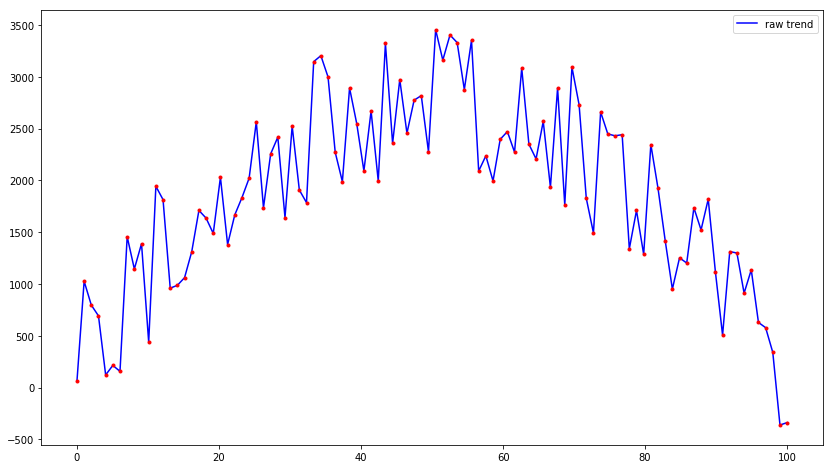

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Plot NOISY temp data
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, y,"r.")
plt.legend()
plt.show()

For prediction purposes, or simply for clearer visualization, we may want to smooth out this trend line. To do this, we can compute the **exponentially weighted averages** (EWA) as follows:

$$\mathbf{V_t}=\beta\cdot \mathbf{V_{t-1}} + (1-\beta)\cdot\theta_t$$

where:
- $\mathbf{V_t}$ represents the exponentially weighted average at timestep $t$
- $\beta$ acts as a smoothing parameter, and effectively determines over how many timesteps we'd like to average our values
- $\theta_t$ is the raw output value at timestep $t$ (e.g. temperature)

It can be shown mathematically that for any value of $\beta$, you will be effectively averaging your values over *approximately* $\frac{1}{1-\beta}$ timesteps. For example:

- $\beta$ = 0.9 will average last 10 entries
- $\beta$ = 0.98 will average last 50 entries
- $\beta$ = 0.5 will average last 2 entries

Let's implement this function with our temperature data and see what it looks like. Note that we have also divided each weighted average value by a **bias correction** term of $(1-\beta^t)$. This helps adjust the values at earlier timesteps as $\mathbf{V_0}=0$, and thus the bias of the weighted averages is shifted (in this case, downwards). Feel free to play around with the parameters, turning the bias correction term on and off, to see how the results are adjusted.

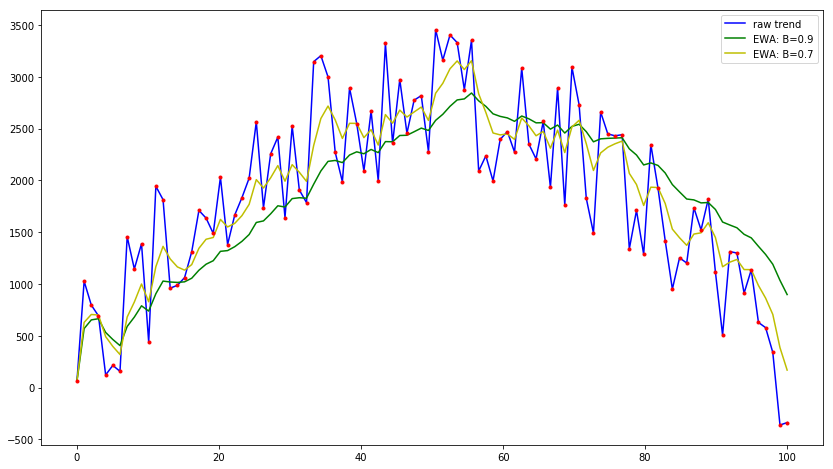

In [0]:
# Create EWA function
def EWA(Y, beta, correct_bias=True):
    updates = []
    v=0
    for t,y in enumerate(Y):
        v = beta*v + (1-beta)*y
        v_bias = v/(1-beta**(t+1)) # Bias correction
        updates.append(v_bias if correct_bias else v)
    return updates

# Plot noisey data and smoothed data
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, EWA(y,0.9), "g-", label = "EWA: B=0.9")
plt.plot(X, EWA(y,0.7), "y-", label = "EWA: B=0.7")

plt.plot(X, y,"r.")
plt.legend()

We now have a beautiful smooth trend line. Now that we understand exponentially weighted averages, let's see how they are applied to optimization methods.

## Momentum Optimization

Recall that gradient descent simply updates the weights $\theta$ by directly subtracting the gradient of the cost function with respect to the weights $\triangledown_\theta J(\theta)$ multiplied by the learning rate $\eta$. The equation is: $\theta \leftarrow \theta – \triangledown_\theta J(\theta)$, and it does not take into consideration the values of earlier gradients. As such, if the local gradient is tiny, training goes very slowly. 

In contrast, momentum optimization takes previous gradients into consideration by calculating the **exponentially weighted average** (called the momentum vector) as it backpropagates through the layers. Mathematically, this can be presented as follows:

1) **Update momentum vector**: $\mathbf{m_t}=\beta\cdot\mathbf{m_{t-1}} + (1-\beta)\cdot \triangledown_\theta J(\theta_t)$

2) **Update weights**: $\theta_t=\theta_{t-1} - \eta\cdot\mathbf{m_t}$

where:
- $\eta$ is the learning rate
- $\triangledown_\theta J(\theta)$ is the gradient of the cost function with respect to $\theta$
- $\beta$ is the momentum hyperparameter, which effectively determines how many of the previous iterations' gradients to take into consideration. It must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9. You can easily see that if momentum is set to zero, then we have plain old gradient descent.
- $\mathbf{m}$ is the momentum vector

Note that in practice, people don't bother implementing **bias correction** with momentum. Here is the pseudocode:

```python
beta = 0.9
lr=0.01
for _ in num_iterations:
    dw = compute_gradients(x, y) # calculate gradients
    momentum = beta * momentum + (1-beta) * dw # update momentum vector
    w = w - lr * momentum # update weights
```

So why does momentum tend to work better than plain old gradient descent? With stochastic gradient descent (SGD), we are computing the gradient of the loss function over subsamples of the training data (mini-batches). This means that we are going to see a lot of volatility with our weight updates, and we will not always be pushing the parameters in the optimal direction. In essence, the gradients are "noisy," just like the temperature data above. That said, exponentially weighed averages can provide us a better estimate of the derivate of the full training set than our noisy mini-batch calculations. This is one reason why momentum might work better than classic SGD.

The other reason lies in **ravines.** A ravine is an area of a parabola where the surface curves much more steeply in one dimension than in another. We want to get down to the minimum, but for that we have to move through the ravine. This type of region is called **pathological curvature**.

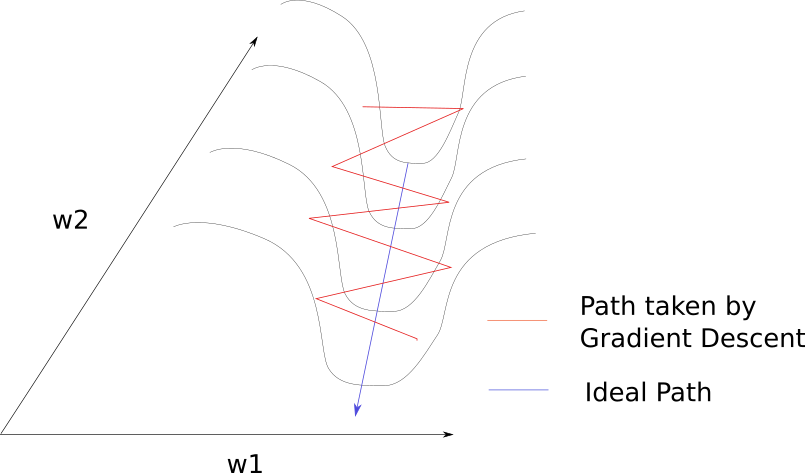

<br><center><i>Mini-batch gradient descent path vs. optimal path towards function minimum.  </i><b>Source</b>: University of Waterloo</center>

It's fairly straightforward to get the hang of what is going on here: gradient descent is bouncing along the ridges of the ravine, and moving a lot slower towards the minimum. This is because the surface at the ridge curves much more steeply in the direction of $w1$. Ravines are common near local minima in deep learning and SGD has troubles navigating them. SGD will tend to oscillate across a narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum.

With momentum optimization, the momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions, thus accumulating "momentum" on the optimal path along the ravine. This allows momentum optimization to escape from plateaus much faster than gradient descent. This is illustrated in the image below.

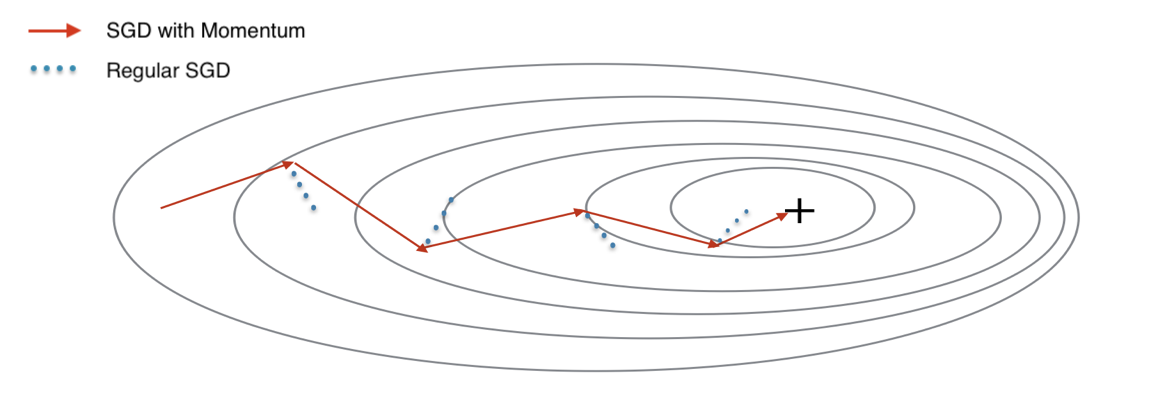

<br><center><i>Red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Notice the more efficient path of gradient descent with momentum when compared to that of SGD.<br></i><b>Source</b>: University of Waterloo</center>

**NOTE:** Due to momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons why it is good to have a bit of friction in the system (a $\beta$ value of around 0.9) &mdash; it gets rid of these oscillations and thus speeds up convergence.

We can implement momentum optimization by changing the optimizer argument in our `model.compile` function as follows:

```python
    optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True )
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
```

**NOTE:** We have set the `nesterov` argument to `True`. This implements the **Nesterov accelerated gradient (NAG)** method, which simply measures the gradient of the cost function not at the local position, but slightly ahead in the direction of the momentum. The only difference is that the gradient is measured at $\theta+\beta\mathbf{m}$ instead of $\theta$. This small tweak works because in general the momentum vector will be pointing in the right direction (i.e. toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position. In general, NAG ends up being significantly faster than regular momentum optimization.
 
Okay, enough theory, let's implement this new algorithm with TensorFlow and Keras. To get started, we will use the `simple_model_bn` as well as the `load_mnist_clean` functions we created in the first part of the module. We have stored both of these functions in the `module11_utils.py` file and have loaded them in for you below (make sure `module11_utiles.py` is stored in the same directory as this notebook). Note that we will use a $\beta$ of 0.9, as this is generally a good place to start and works very well in most cases.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from module11_utils import load_mnist_clean, simple_model_bn

# Load data
X_train, X_test, y_train, y_test = load_mnist_clean()

X_train: (60000, 784)
y_train: (60000, 10)
X_test: (10000, 784)
y_test: (10000, 10)
Min: -1.2862206407261398
Max: 244.94693302869902
X dtype: float64
y dtype: float64


In [0]:
# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizer
optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

# Run model
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/sample - loss: 1.8676 - acc: 0.3759 - val_loss: 2.2754 - val_acc: 0.2841
Epoch 2/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.8888 - acc: 0.7801 - val_loss: 2.2216 - val_acc: 0.2764
Epoch 3/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.5434 - acc: 0.8643 - val_loss: 2.1524 - val_acc: 0.2773
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.4076 - acc: 0.8964 - val_loss: 2.0772 - val_acc: 0.3081
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3368 - acc: 0.9122 - val_loss: 1.9891 - val_acc: 0.4044
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2920 - acc: 0.9230 - val_loss: 1.8832 - val_acc: 0.5111
Epoch 7/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2593 - acc: 0.9312 - val_loss: 1.

Wow, ~90% validation accuracy in just ten epochs! And we were only using `random_normal` initialization! That's pretty impressive. This is the power of momentum.

## AdaGrad Optimization

The AdaGrad optimizer is similar to the momentum algorithm in that it tends to find a more direct path to the global minimum as compared to "vanilla" or plain old gradient descent. However, it does so by trying to solve the problem of widely varying gradient magnitudes. Some gradients may be tiny and others may be huge, which can result in a very difficult problem: trying to find a single global learning rate for the algorithm.

This is sometimes called the elongated bowl problem: gradient descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. It's worth noting that we can’t simply solve this problem by increasing the learning rates. The steps we take with large gradients will be even bigger, which may result in divergence. 

The AdaGrad algorithm attempts to solve this problem by scaling down the gradient vector along the steepest dimension and increasing the gradient vectors along the flattest dimensions.

To do this, AdaGrad first accumulates the squared gradients into a vector $\mathbf{s}$. The algorithm then uses the root of this vector to scale the update vector ($\eta\cdot\triangledown_\theta J(\theta_t)$. If the cost function is steep along the $i^{th}$ dimension, then $\mathbf{s^i}$ will get larger and larger at each iteration. This process can be represented mathematically as follows:

1) **Accumulate squared gradient vector**:  $\mathbf{s_t}=\mathbf{s_{t-1}} + (\triangledown_\theta J(\theta_t))^2$

2) **Update weights**: $\theta_t=\theta_{t-1} + - \frac{\eta}{s_t+\epsilon}\cdot\triangledown_\theta J(\theta_t)$

The notation is similar to that of the momentum equations above, however here we are **not** taking a moving average (we are simply accumulating squared gradient values), and we are also dividing the learning rate by $\mathbf{s_t}$ (this is what adjusts the value of the updates based on the previous gradients' size or steepness). Note that in order to ensure that we are not dividing by zero, we add a small value $\epsilon$ (e.g. `epsilon = 10^-8`) to $\mathbf{s_t}$.

For additional clarity, the process can be represented in psuedocode as follows:

```python
grads_squared = 0
lr=0.01
epsilon = 1e-08
for _ in num_iterations:
    dw = compute_gradients(x, y)
    grads_squared += grads_squared + dw * dw # element wise multiplication (squaring gradients)
    w = w - (lr / np.sqrt(grads_squared+epsilon)) * dw
```

As you can see, the algorithm is almost identical to gradient descent, but with one big difference: the gradient vector is scaled down by a factor of `np.sqrt(grads_squared+epsilon)`. This algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an **adaptive learning rate**. It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.

We can implement AdaGrad optimization by changing the optimizer argument in our `model.compile` function as follows:

```python
    optimizer = tf.keras.optimizers.Adagrad(lr=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
```

Let's try it out.

In [0]:
# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizer
optimizer = tf.keras.optimizers.Adagrad(lr=0.01)

# Run model
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples


W0719 00:08:28.374295 139744303077248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/10
60000/60000 [==============================] - 2s 27us/sample - loss: 1.8522 - acc: 0.4017 - val_loss: 2.2924 - val_acc: 0.1781
Epoch 2/10
60000/60000 [==============================] - 1s 15us/sample - loss: 1.2344 - acc: 0.6657 - val_loss: 2.2816 - val_acc: 0.1421
Epoch 3/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.9245 - acc: 0.7753 - val_loss: 2.2657 - val_acc: 0.1336
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.7417 - acc: 0.8285 - val_loss: 2.2422 - val_acc: 0.1403
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.6285 - acc: 0.8562 - val_loss: 2.2101 - val_acc: 0.1804
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.5513 - acc: 0.8735 - val_loss: 2.1668 - val_acc: 0.2823
Epoch 7/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4947 - acc: 0.8863 - val_loss: 2.1108 - val_acc: 0.3957
Epoch 8/10
60000/60000 [===

Not bad! AdaGrad often performs well for simple problems (like this one), but unfortunately **it often stops too early when training neural networks**. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though `tf.keras.optimizers.Adagrad` does exist, it's probably not your best choice for training super deep neural network models (though it may be efficient for simpler tasks such as linear regression).

## RMSprop Optimization

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSprop algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients from the beginning of training). RMSprop takes the *exponentially weighted average* of the squared gradients at every step (the RMS in RMSprop stands for *root mean squared*). This is the same as the momentum vector, but we are simply squaring the gradients. We then use the root of this vector to scale the update vector ($\eta\cdot\triangledown_\theta J(\theta_t)$, just as we did with AdaGrad. This can be represented mathematically as follows:

1) **Update squared gradient vector**: $\mathbf{s_t}=\beta\cdot\mathbf{s_{t-1}} + (1-\beta)\cdot (\triangledown_\theta J(\theta_t))^2$

2) **Update weights**: $\theta_t=\theta_{t-1} + - \frac{\eta}{s_t+\epsilon}\cdot\triangledown_\theta J(\theta_t)$

The notation is similar to that of the momentum equations, we have just squared the gradients in the first equation and replaced the momentum vector $\mathbf{m}$ with the squared gradient vector $\mathbf{s}$. For additional clarity, the process can be represented in pseudocode as follows:

```python
grads_squared = 0
beta = 0.9
lr=0.01
epsilon = 1e-08
for _ in num_iterations:
    dw = compute_gradients(x, y)
    grads_squared = beta * grads_squared + (1-beta) * dw * dw # element wise multiplication (squaring gradients)
    w = w - (lr / np.sqrt(grads_squared+epsilon)) * dw
```
What we are effectively doing here is *increasing* the updates for small gradients, and *decreasing* the updates for large gradients, just as we did with AdaGrad &mdash; the key difference being that we use the exponential average so that our gradients don't increase or decrease too quickly. This adjustment helps a great deal with saddle points and plateaus.

We can implement RMSprop optimization by changing the optimizer argument in our `model.compile` function as follows:

```python
    optimizer = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
```
In  the `RMSprop` function, `rho` represents the exponentially weighted average decay factor ($\beta$). Let's implement this optimizer and see how our results change.

In [0]:
# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-8)

# Run model
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.8747 - acc: 0.7222 - val_loss: 1.8336 - val_acc: 0.6450
Epoch 2/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2684 - acc: 0.9212 - val_loss: 1.4964 - val_acc: 0.7964
Epoch 3/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1949 - acc: 0.9412 - val_loss: 1.1361 - val_acc: 0.8441
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1384 - acc: 0.9588 - val_loss: 0.9351 - val_acc: 0.7808
Epoch 5/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.1397 - acc: 0.9583 - val_loss: 0.5348 - val_acc: 0.9050
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0997 - acc: 0.9700 - val_loss: 0.3798 - val_acc: 0.9106
Epoch 7/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0907 - acc: 0.9720 - val_loss: 0.

~90% validation accuracy in just ten epochs again! This is similar to the results we got with momentum. Next, we will learn about the **Adam optimizer** which effectively takes the above approaches (namely momentum and RMSprop) and combines them.  

## Adam Optimization

Adam, which stands for **adaptive moment estimation**, combines the ideas of momentum optimization and RMSprop. Just like momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSprop it keeps track of an exponentially decaying average of past *squared* gradients. Since Adam is an adaptive learning rate algorithm (like RMSprop), it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making Adam even easier to use than gradient descent. The algorithm can be represented mathematically as follows:

1) **Update momentum and squared gradients vectors**:

- $\mathbf{m_t}=\beta_1\cdot\mathbf{m_{t-1}} + (1-\beta_1)\cdot \triangledown_\theta J(\theta_t)$

- $\mathbf{s_t}=\beta_2\cdot\mathbf{s_{t-1}} + (1-\beta_2)\cdot (\triangledown_\theta J(\theta_t))^2$

2) **Adjust bias**:


- $\mathbf{m_t} = \frac{\mathbf{m_t}}{1-\beta_1^t}$
- $\mathbf{s_t} = \frac{\mathbf{s_t}}{1-\beta_2^t}$

3) **Update weights**:

- $\theta_t=\theta_{t-1} + - \frac{\eta}{s_t+\epsilon}\cdot\mathbf{m_t}$


The parameters are very similar to what we saw with momentum and RMSprop. However, we have added $\beta_1$ and $\beta_2$ as we apply separate decay factors to each component. The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term ϵ is usually initialized to a tiny number such as 10e–8. We also adjust the $\mathbf{m_t}$ and $\mathbf{s_t}$ for bias (as explained in the exponentially weighted average section above), which is commonly done with Adam.

Here is the pseudocode:

```python
grads_squared = 0
beta1 = 0.9
beta2 = 0.99
lr=0.01
epsilon = 1e-08
for i in range(1, num_iterations+1):
    # Caclulate gradient
    dw = compute_gradients(x, y)
    # Calculate momentum and RMSprop averages
    grads_momentum = beta1 * grads_momentum + (1-beta1) * dw
    grads_squared = beta2 * grads_squared + (1-beta2) * dw * dw 
    # Fix bias
    grads_momentum = grads_momentum / (1 - beta1**i)
    grads_squared = grads_squared / (1 - beta2**i
    # Make updates
    w = w - (lr / np.sqrt(grads_squared+epsilon)) * grads_momentum # Make updates
```

We can implement momentum optimization by changing the optimizer argument in our `model.compile` function as follows:

```python
    optimizer = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
```

Let's try it out.

In [0]:
# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Run model
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.8723 - acc: 0.7472 - val_loss: 1.7223 - val_acc: 0.7251
Epoch 2/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2385 - acc: 0.9311 - val_loss: 1.3234 - val_acc: 0.7816
Epoch 3/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1517 - acc: 0.9546 - val_loss: 1.0717 - val_acc: 0.8549
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1100 - acc: 0.9684 - val_loss: 0.8770 - val_acc: 0.8851
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0862 - acc: 0.9747 - val_loss: 0.6817 - val_acc: 0.8947
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0679 - acc: 0.9806 - val_loss: 0.5879 - val_acc: 0.8912
Epoch 7/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0562 - acc: 0.9843 - val_loss: 0.

Again, pretty solid results! We didn't see a huge bump in accuracy here, but that is likely because we are only running the model for 10 epochs, and also because this is a fairly simple dataset (Adam tends to out perform RMSprop and momentum when the complexity of the dataset increases).

**Exercise 3**

Try running Momentum, RMSprop, and Adam for 20 to 30 epochs. Do you see a difference in the accuracy at a certain point? 

In [ ]:
# Your work here

In [ ]:
# Your work here

In [ ]:
# Your work here

**Exercise 3 Solution**

Running VanillaSGD model...
Running Momentum model...
Running AdaGrad model...
Running RMS model...
Running Adam model...


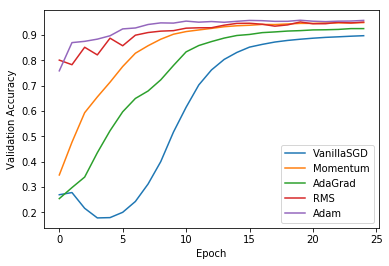

CPU times: user 2min 45s, sys: 7.96 s, total: 2min 53s
Wall time: 2min


In [0]:
%%time
"""NOTE: running all models should take 2-3 minutes."""

# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizers
op0 = tf.keras.optimizers.SGD(lr=0.01) # Standard SGD
op1 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
op2 = tf.keras.optimizers.Adagrad(lr=0.01)
op3 = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-8)
op4 = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Run models
results = {}
for optimizer, name in [(op0, 'VanillaSGD'), (op1, 'Momentum'),(op2,'AdaGrad'), (op3, 'RMS'),(op4, "Adam")]:
    print("Running {} model...".format(name))
    model = simple_model_bn(init, activate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    out = model.fit(X_train, y_train, epochs=25, batch_size=3200, validation_data=(X_test, y_test), verbose=0) #turn off verbosity
    results[name] = out.history['val_acc']
    plt.plot(out.history['val_acc'], label=name)
    
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

As we can see from the above exercise, Adam seems to converge faster than AdaGrad and RMSprop. While your results will always depend on the type of model you are building, as well as the data itself, in general **Adam will more quickly and efficiently find the global minimum of your loss function.**

## Learning Rate Scheduling

Now that we have a solid handle on deep learning optimizers and how to implement them, we are going to discuss one final topic to help you refine model training: **learning rate scheduling**.

Finding a good learning rate can be tricky:

- If you set it way too high, training may actually diverge


- If you set it too low, training will eventually converge to the optimum, but it will take a very long time


- If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSprop, or Adam, but even then it may take time to settle)


- If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution

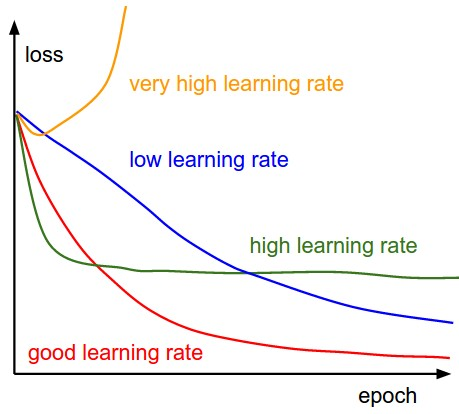

<br><center><i>Model training performance based on different learning rate schedules. Note that this is a generalization, and your results will always depend on the data and model architecture. </i><b>Source</b>: University of Waterloo</center>

The ideal learning rate will learn quickly and converge to good solution. However, you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate.

There are many different strategies to reduce the learning rate during training. These strategies are called **learning schedules**, the most common of which are:

- **Learning rate decay**: The learning rate is updated at the end of each mini-batch as follows: $\eta_t = \eta_0 \cdot \frac{1}{1+\beta \cdot t}$, where $\eta_t$ is the learning rate for the current epoch, $\eta_0$ is the base learning rate specified as an argument to SGD, $\beta$ is the decay rate which is greater than zero, and $t$ is the current iteration number.


- **Predetermined piecewise constant learning rate**: The learning rate reduces based on predefined update steps. For example, set the learning rate to $\eta_0 = 0.01$ at first, then to $\eta_1 = 0.001$ after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.


- **Performance scheduling**: Measure the validation error every N steps and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.


- **Exponential scheduling**: Set the learning rate to a function of the iteration number $t: \eta_t = \eta_0 \cdot 10^{\frac{–t}{r}}$. This works great, but it requires tuning $\eta_0$ and $r$. The learning rate will drop by a factor of 10 every $r$ steps.


- **Power scheduling**: Set the learning rate to $t: \eta_t = \eta_0 \cdot (1+\frac{t}{r})^{-c}$. The hyperparameter $c$ is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly. 

A 2013 paper by Andrew Senior et al. compared the performance of some of the most popular learning schedules when training deep neural networks for speech recognition using momentum optimization. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well, but they favored exponential scheduling because it is simpler to implement, is easy to tune, and converged slightly faster to the optimal solution.

With `tf.keras`, you can use the `decay` argument in most optimization algorithms (e.g. ```tf.keras.optimizers.SGD(lr=0.01, decay=0.9)```) to implement "learning rate decay". However, if you want to use more sophisticated learning rate scheduling methods, you will have to use Keras callbacks.

As we have discussed in previous sections, callbacks are instantiated and configured, then specified in a list to the `callbacks` argument of the `fit()` function when training the model. Keras provides the `ReduceLROnPlateau` callback (similar to the performance scheduling technique listed above) that will adjust the learning rate when a plateau in model performance is detected (e.g. no change in `val_acc` for given number of training epochs). This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.

The `ReduceLROnPlateau` requires you to specify three arguments:

- **`monitor`**: Which metric to monitor during training
- **`factor`**: The value that the learning rate will be multiplied by 
- **`patience`**: The number of training epochs to wait before triggering the change in learning rate

For example, we can monitor the validation loss and reduce the learning rate by an order of magnitude if validation loss does not improve for 100 epochs with the following code:

```python
from keras.callbacks import ReduceLROnPlateau
...
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
model.fit(..., callbacks=[rlrop])
```

Keras also provides the `LearningRateScheduler` callback that allows you to specify a custom function that is called each epoch in order to adjust the learning rate. You can define your Python function that takes two arguments (epoch and current learning rate) and returns the new learning rate. Here is an example of how this would look:

```python
from keras.callbacks import LearningRateScheduler
...

def my_learning_rate(epoch, prev_lrate)
    # perform some computations
    ...
	return new_lrate

lrs = LearningRateScheduler(my_learning_rate)
model.fit(..., callbacks=[lrs])
```

It should be noted that since AdaGrad, RMSprop, and Adam optimization automatically reduce the learning rate during training, it is generally not necessary to add an extra learning schedule. For other optimization algorithms, using exponential decay or performance scheduling can considerably speed up convergence. In fact, it is recommended to use SGD when using a learning rate schedule callback.

**End of Part 2**

This notebook makes up one part of this module. Now that you have completed this part, please proceed to the next notebook in this module.

If you have any questions, please reach out to your peers using the discussion boards. If you and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to your instructor on the designated discussion board.

# References

- Senior, A., Heigold, G., Ranzato M., & Yang, K. (2013). An Empirical Study of Learning Rates in Deep Neural Networks for Speech Recognition. Conference Paper: ICASSP 2013 - IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) DOI: 10.1109/ICASSP.2013.6638963. https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/40808.pdf